In [1]:
"""
All tastes stacked
Different lambdas for each taste but same tau
SINGLE NEURON
"""

'\nAll tastes stacked\nDifferent lambdas for each taste but same tau\nSINGLE NEURON\n'

In [269]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.stats import percentileofscore

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [402]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200228_151511/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params
dat.firing_rate_params['type'] = 'baks'
dat.firing_rate_params['baks_resolution'] = 10e-3

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat.get_stft()
print(np.array(dat.spikes).shape)



  0%|          | 0/810 [00:00<?, ?it/s]

  3%|▎         | 22/810 [00:00<00:03, 214.72it/s]

  6%|▌         | 48/810 [00:00<00:03, 224.83it/s]

  9%|▊         | 70/810 [00:00<00:03, 222.91it/s]

 11%|█▏        | 92/810 [00:00<00:03, 221.26it/s]

 14%|█▍        | 114/810 [00:00<00:03, 219.81it/s]

 17%|█▋        | 134/810 [00:00<00:03, 212.97it/s]

 19%|█▉        | 157/810 [00:00<00:03, 214.74it/s]

 23%|██▎       | 184/810 [00:00<00:02, 225.51it/s]

 26%|██▌       | 208/810 [00:00<00:02, 228.97it/s]

 29%|██▊       | 231/810 [00:01<00:02, 218.40it/s]

 31%|███       | 253/810 [00:01<00:02, 216.74it/s]

 34%|███▍      | 275/810 [00:01<00:02, 213.18it/s]

 37%|███▋      | 297/810 [00:01<00:02, 201.42it/s]

 40%|███▉      | 322/810 [00:01<00:02, 210.45it/s]

 42%|████▏     | 344/810 [00:01<00:02, 211.56it/s]

 45%|████▌     | 366/810 [00:01<00:02, 204.30it/s]

 48%|████▊     | 392/810 [00:01<00:01, 213.29it/s]

 51%|█████     | 414/810 [00:01<00:01, 214.15it/s]

 54%|█████▍    | 436/810 

All tastes have equal dimensions,concatenating and normalizing
(4, 30, 27, 7000)


In [390]:
print(dat.stft_array.shape)

(4, 18, 30, 10, 5000)


(27, 120, 280)


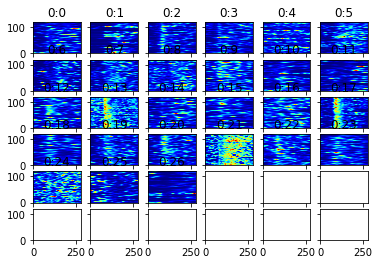

In [391]:
visualize.firing_overview(dat.all_normalized_firing);
print(dat.all_normalized_firing.shape)

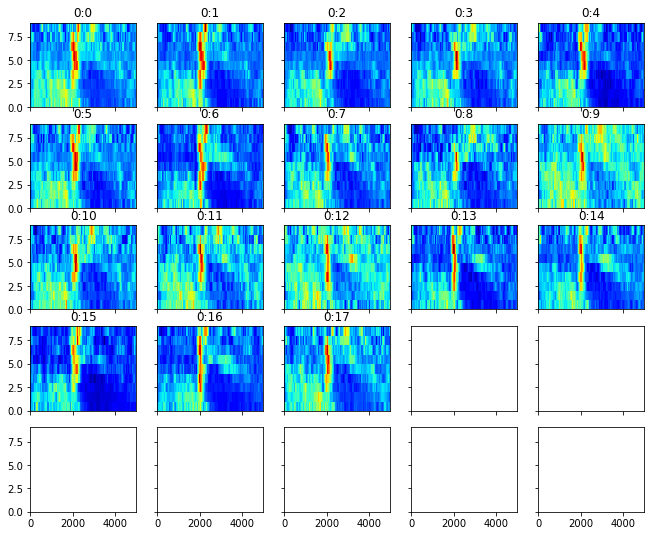

In [6]:
median_amplitude = np.median(dat.amplitude_array,axis=(0,2))
visualize.firing_overview(stats.zscore(median_amplitude,axis=-1));

In [7]:
nrn = np.arange(np.array(dat.spikes).shape[2])
taste_dat = np.array(dat.spikes)[:,:,nrn]
#taste_dat = np.array(dat.spikes)[:,:,nrn]
print(taste_dat.shape)

(4, 30, 27, 7000)


In [94]:
# Convert spikes to counts by binning
time_lims = [2000,4500]
bin_width = 10
t_vec = np.arange(taste_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
whole_dat_binned = np.sum(taste_dat.reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.sum(taste_dat[...,time_lims[0]:time_lims[1]].reshape(*taste_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

print(this_dat_binned.shape)
print(whole_dat_binned.shape)
print(binned_t_vec)

(4, 30, 27, 250)
(4, 30, 27, 700)
[2004.5 2014.5 2024.5 2034.5 2044.5 2054.5 2064.5 2074.5 2084.5 2094.5
 2104.5 2114.5 2124.5 2134.5 2144.5 2154.5 2164.5 2174.5 2184.5 2194.5
 2204.5 2214.5 2224.5 2234.5 2244.5 2254.5 2264.5 2274.5 2284.5 2294.5
 2304.5 2314.5 2324.5 2334.5 2344.5 2354.5 2364.5 2374.5 2384.5 2394.5
 2404.5 2414.5 2424.5 2434.5 2444.5 2454.5 2464.5 2474.5 2484.5 2494.5
 2504.5 2514.5 2524.5 2534.5 2544.5 2554.5 2564.5 2574.5 2584.5 2594.5
 2604.5 2614.5 2624.5 2634.5 2644.5 2654.5 2664.5 2674.5 2684.5 2694.5
 2704.5 2714.5 2724.5 2734.5 2744.5 2754.5 2764.5 2774.5 2784.5 2794.5
 2804.5 2814.5 2824.5 2834.5 2844.5 2854.5 2864.5 2874.5 2884.5 2894.5
 2904.5 2914.5 2924.5 2934.5 2944.5 2954.5 2964.5 2974.5 2984.5 2994.5
 3004.5 3014.5 3024.5 3034.5 3044.5 3054.5 3064.5 3074.5 3084.5 3094.5
 3104.5 3114.5 3124.5 3134.5 3144.5 3154.5 3164.5 3174.5 3184.5 3194.5
 3204.5 3214.5 3224.5 3234.5 3244.5 3254.5 3264.5 3274.5 3284.5 3294.5
 3304.5 3314.5 3324.5 3334.5 3344.5 3354.5 

(4, 27, 50)


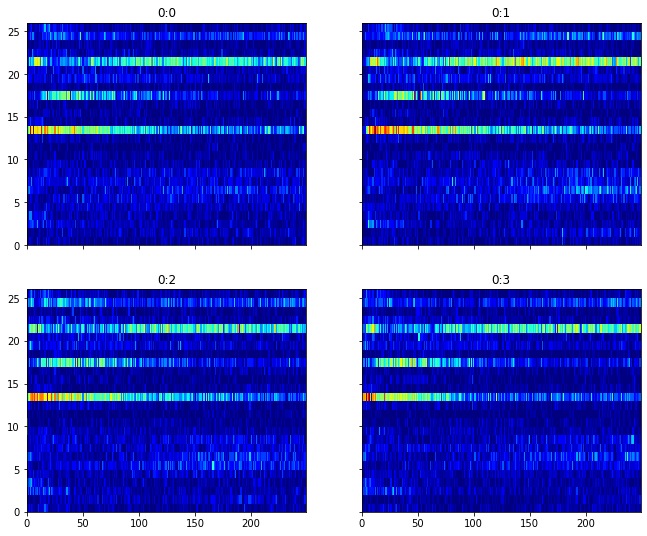

In [45]:
mean_this_dat = np.mean(this_dat_binned,axis=1)
print(zscore_this_dat.shape)
visualize.firing_overview(mean_this_dat);

(120, 27, 250)
(120, 27, 700)


<Figure size 792x648 with 0 Axes>

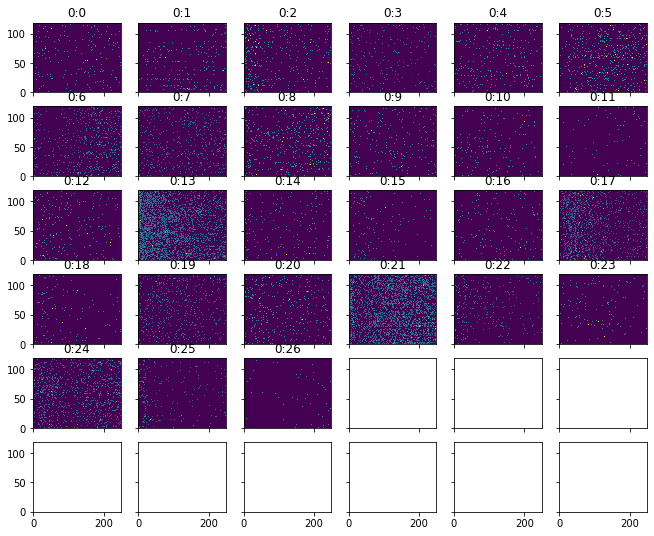

In [96]:
# Pick single trial
trial = np.arange(taste_dat.shape[1])
taste = np.arange(taste_dat.shape[0])

dat_binned_long = np.reshape(this_dat_binned,(-1,*this_dat_binned.shape[-2:]))
whole_dat_binned_long = np.reshape(whole_dat_binned,(-1,*whole_dat_binned.shape[-2:]))
print(dat_binned_long.shape)
plt.figure();
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');
print(whole_dat_binned_long.shape)
#dat_binned_long[dat_binned_long>1] = 1
# plt.figure();
# visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [322]:
states = 5
tastes = this_dat_binned.shape[0]
split_list = np.array_split(this_dat_binned,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
print(split_array.shape)
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
# print(mean_vals)
mean_nrn_vals = np.mean(mean_vals,axis=(0,1))
print(mean_nrn_vals.shape) # Trials x nrns

(5, 4, 30, 27, 50)
(4, 5, 27)
(27,)


In [323]:
idx = np.arange(this_dat_binned.shape[-1]) # Index
array_idx = np.broadcast_to(idx, dat_binned_long.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
249
(120, 27, 250)


In [324]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[  0.   49.8  99.6 149.4 199.2 249. ]
[0.2 0.4 0.6 0.8]


(27,)
(5, 27)
(4, 5, 27)


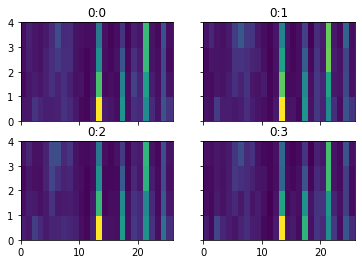

In [325]:
with pm.Model() as model:
    
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    # Shared hyperprior for single neuron (across tastes and states)
#     a_lambda = 2
#     b_lambda = 5
    # Priors for each neuron
    lambda_nrn = pm.Exponential('lambda_nrn',1/mean_nrn_vals, shape = (mean_vals.shape[-1]))
#     b_lambda = pm.HalfNormal('b_lambda',3, shape = (mean_vals.shape[-1]))
    
    # Priors for each state, derived from each neuron
    lambda_state = pm.Exponential('lambda_state',lambda_nrn, shape = (mean_vals.shape[1:]))
#     sig_lambda_state = pm.HalfNormal('sig_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
#     a_lambda_state = pm.HalfNormal('a_lambda_state',a_lambda, shape = (mean_vals.shape[1:]))
#     b_lambda_state = pm.HalfNormal('b_lambda_state',b_lambda, shape = (mean_vals.shape[1:]))
    
    lambda_latent = pm.Exponential('lambda', lambda_state[np.newaxis,:,:], testval = mean_vals, 
                            shape = (mean_vals.shape))

print(lambda_nrn.tag.test_value.shape)
print(lambda_state.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

visualize.firing_overview(lambda_latent.tag.test_value,cmap='viridis');

In [326]:
trial_num = array_idx.shape[0]

with model:
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3., shape = states - 1)
    b = pm.HalfNormal('b_tau', 3., shape = states - 1)
    
    # Stack produces states x trials --> That gets transposed to trials x states and gets sorted along states (axis=-1)
    # Sort should work the same way as the Ordered transform --> see rv_sort_test.ipynb

    tau_latent = pm.Beta('tau_latent', a, b, 
                           shape = (trial_num, states-1),
                        testval = tt.tile(even_switches_normal[1:(states)],(array_idx.shape[0],1))).sort(axis=-1)
       
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)

print(tau.tag.test_value.shape)
tau_test_value = tau.tag.test_value

(120, 4)


In [327]:
print(array_idx.shape)

(120, 27, 250)


In [328]:
print(tt.tile(array_idx,(3,1,1,1)).swapaxes(0,1).tag.test_value.shape)

(120, 3, 27, 250)


In [332]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    weight_1_stack = tt.nnet.sigmoid(array_idx - tau[:,0][...,np.newaxis,np.newaxis])
    weight_2_stack = tt.nnet.sigmoid(array_idx - tau[:,1][...,np.newaxis,np.newaxis])
    weight_3_stack = tt.nnet.sigmoid(array_idx - tau[:,2][...,np.newaxis,np.newaxis])
    weight_4_stack = tt.nnet.sigmoid(array_idx - tau[:,3][...,np.newaxis,np.newaxis])

#     tau = tau[...,np.newaxis,np.newaxis]
#     weight_stack = tt.nnet.sigmoid(tt.tile(array_idx,(states-1,1,1,1)).swapaxes(0,1) - tau)
    
print(weight_1_stack.tag.test_value.shape)
print(lambda_latent.tag.test_value.shape)

(120, 27, 250)
(4, 5, 27)


In [333]:
weight_1_test =  weight_1_stack.tag.test_value[0]
lambda_latent_test = lambda_latent.tag.test_value[0]
print(weight_1_test.shape)
print(lambda_latent_test.shape)

(27, 250)
(5, 27)


In [335]:
with model:
    
    taste_label = np.repeat([0,1,2,3],30)
    
#     # 3 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack, lambda_latent[taste_label,2][:,:,np.newaxis])
    
#     # 4 states
#     lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
#                 np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
#                 np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) + \
#                 np.multiply(weight_3_stack, lambda_latent[taste_label,3][:,:,np.newaxis])
    
    # 5 states
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[taste_label,0][:,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[taste_label][:,1][:,:,np.newaxis]) + \
                np.multiply(weight_2_stack * (1 - weight_3_stack), lambda_latent[taste_label][:,2][:,:,np.newaxis]) +\
                np.multiply(weight_3_stack * (1 - weight_4_stack), lambda_latent[taste_label][:,3][:,:,np.newaxis])+ \
                np.multiply(weight_4_stack, lambda_latent[taste_label,4][:,:,np.newaxis])

#     lambda_latent_temp = lambda_latent[taste_label,:,:,np.newaxis]
#     print(lambda_latent.tag.test_value.shape)
#     print(lambda_latent_temp.tag.test_value.shape)
    
#     lambda_ = np.multiply(1 - weight_stack[:,0], lambda_latent_temp[:,0]) + \
#                 np.multiply(weight_stack[:,0] * (1 - weight_stack[:,1]), lambda_latent_temp[:,1]) + \
#                 np.multiply(weight_stack[:,1] * (1 - weight_stack[:,2]), lambda_latent_temp[:,2]) + \
#                 np.multiply(weight_stack[:,2], lambda_latent_temp[:,3])

(120, 27, 250)
(120, 27, 250)


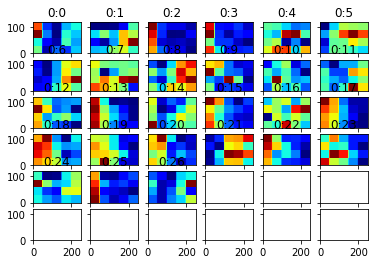

<Figure size 432x288 with 0 Axes>

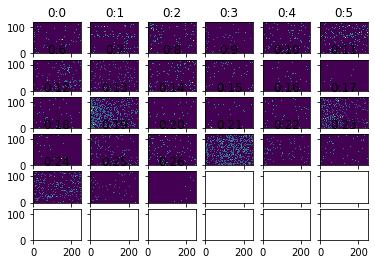

In [336]:
# print(taste_label)
print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
visualize.firing_overview(lambda_.tag.test_value.swapaxes(0,1));
plt.figure()
visualize.firing_overview(dat_binned_long.swapaxes(0,1),cmap='viridis');

In [337]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Poisson("obs", lambda_, observed=dat_binned_long)

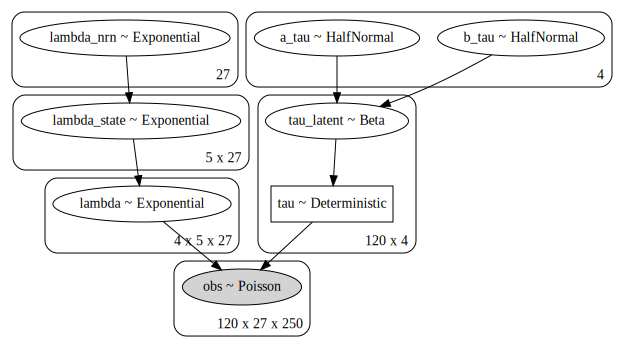

In [338]:
pm.model_to_graphviz(model)

In [339]:
with model:
    #step= pm.Metropolis()
    #step= pm.NUTS()
    #trace = pm.sample(100, tune=10,
    #                  step = step,
    #                  chains = 30, cores = 30)
    inference = pm.ADVI('full-rank')
    approx = pm.fit(n=40000, method=inference)
    trace = approx.sample(draws=20000)



  0%|          | 0/40000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Average Loss = 1.9904e+05:   0%|          | 0/40000 [00:00<?, ?it/s]

Average Loss = 1.9904e+05:   0%|          | 0/40000 [00:00<?, ?it/s]

Average Loss = 1.9904e+05:   0%|          | 2/40000 [00:00<54:29, 12.23it/s]

Average Loss = 1.9904e+05:   0%|          | 4/40000 [00:00<54:00, 12.34it/s]

Average Loss = 1.9904e+05:   0%|          | 6/40000 [00:00<53:34, 12.44it/s]

Average Loss = 1.9904e+05:   0%|          | 8/40000 [00:00<53:39, 12.42it/s]

Average Loss = 1.9904e+05:   0%|          | 10/40000 [00:00<53:55, 12.36it/s]

Average Loss = 1.9

Average Loss = 1.9871e+05:   0%|          | 130/40000 [00:10<53:49, 12.34it/s]

Average Loss = 1.9871e+05:   0%|          | 130/40000 [00:10<53:49, 12.34it/s]

Average Loss = 1.9871e+05:   0%|          | 132/40000 [00:10<54:35, 12.17it/s]

Average Loss = 1.9871e+05:   0%|          | 134/40000 [00:10<54:25, 12.21it/s]

Average Loss = 1.9871e+05:   0%|          | 136/40000 [00:11<54:25, 12.21it/s]

Average Loss = 1.9871e+05:   0%|          | 138/40000 [00:11<54:11, 12.26it/s]

Average Loss = 1.9871e+05:   0%|          | 140/40000 [00:11<54:16, 12.24it/s]

Average Loss = 1.986e+05:   0%|          | 140/40000 [00:11<54:16, 12.24it/s] 

Average Loss = 1.986e+05:   0%|          | 140/40000 [00:11<54:16, 12.24it/s]

Average Loss = 1.986e+05:   0%|          | 142/40000 [00:11<55:09, 12.04it/s]

Average Loss = 1.986e+05:   0%|          | 144/40000 [00:11<54:44, 12.13it/s]

Average Loss = 1.986e+05:   0%|          | 146/40000 [00:11<54:18, 12.23it/s]

Average Loss = 1.986e+05:   0%|          | 1

Average Loss = 1.9799e+05:   1%|          | 266/40000 [00:21<54:07, 12.24it/s]

Average Loss = 1.9799e+05:   1%|          | 268/40000 [00:21<53:57, 12.27it/s]

Average Loss = 1.9799e+05:   1%|          | 270/40000 [00:21<54:06, 12.24it/s]

Average Loss = 1.9792e+05:   1%|          | 270/40000 [00:22<54:06, 12.24it/s]

Average Loss = 1.9792e+05:   1%|          | 270/40000 [00:22<54:06, 12.24it/s]

Average Loss = 1.9792e+05:   1%|          | 272/40000 [00:22<54:18, 12.19it/s]

Average Loss = 1.9792e+05:   1%|          | 274/40000 [00:22<54:17, 12.19it/s]

Average Loss = 1.9792e+05:   1%|          | 276/40000 [00:22<54:38, 12.12it/s]

Average Loss = 1.9792e+05:   1%|          | 278/40000 [00:22<54:13, 12.21it/s]

Average Loss = 1.9792e+05:   1%|          | 280/40000 [00:22<53:56, 12.27it/s]

Average Loss = 1.9787e+05:   1%|          | 280/40000 [00:22<53:56, 12.27it/s]

Average Loss = 1.9787e+05:   1%|          | 280/40000 [00:22<53:56, 12.27it/s]

Average Loss = 1.9787e+05:   1%|        

Average Loss = 1.9741e+05:   1%|          | 400/40000 [00:32<54:01, 12.22it/s]

Average Loss = 1.9741e+05:   1%|          | 402/40000 [00:32<54:31, 12.11it/s]

Average Loss = 1.9741e+05:   1%|          | 404/40000 [00:32<54:05, 12.20it/s]

Average Loss = 1.9741e+05:   1%|          | 406/40000 [00:32<53:50, 12.26it/s]

Average Loss = 1.9741e+05:   1%|          | 408/40000 [00:33<53:44, 12.28it/s]

Average Loss = 1.9741e+05:   1%|          | 410/40000 [00:33<53:34, 12.32it/s]

Average Loss = 1.9736e+05:   1%|          | 410/40000 [00:33<53:34, 12.32it/s]

Average Loss = 1.9736e+05:   1%|          | 410/40000 [00:33<53:34, 12.32it/s]

Average Loss = 1.9736e+05:   1%|          | 412/40000 [00:33<53:35, 12.31it/s]

Average Loss = 1.9736e+05:   1%|          | 414/40000 [00:33<53:35, 12.31it/s]

Average Loss = 1.9736e+05:   1%|          | 416/40000 [00:33<53:42, 12.29it/s]

Average Loss = 1.9736e+05:   1%|          | 418/40000 [00:33<53:25, 12.35it/s]

Average Loss = 1.9736e+05:   1%|        

Average Loss = 1.9693e+05:   1%|▏         | 538/40000 [00:43<54:23, 12.09it/s]

Average Loss = 1.9693e+05:   1%|▏         | 540/40000 [00:43<53:48, 12.22it/s]

Average Loss = 1.9691e+05:   1%|▏         | 540/40000 [00:43<53:48, 12.22it/s]

Average Loss = 1.9691e+05:   1%|▏         | 540/40000 [00:43<53:48, 12.22it/s]

Average Loss = 1.9691e+05:   1%|▏         | 542/40000 [00:44<54:38, 12.03it/s]

Average Loss = 1.9691e+05:   1%|▏         | 544/40000 [00:44<54:20, 12.10it/s]

Average Loss = 1.9691e+05:   1%|▏         | 546/40000 [00:44<53:55, 12.20it/s]

Average Loss = 1.9691e+05:   1%|▏         | 548/40000 [00:44<53:58, 12.18it/s]

Average Loss = 1.9691e+05:   1%|▏         | 550/40000 [00:44<53:37, 12.26it/s]

Average Loss = 1.9687e+05:   1%|▏         | 550/40000 [00:44<53:37, 12.26it/s]

Average Loss = 1.9687e+05:   1%|▏         | 550/40000 [00:44<53:37, 12.26it/s]

Average Loss = 1.9687e+05:   1%|▏         | 552/40000 [00:44<54:05, 12.15it/s]

Average Loss = 1.9687e+05:   1%|▏       

KeyboardInterrupt: 

In [ ]:
pm.save_trace(trace,os.path.join(data_dir,'saved_models',f'vi_{states}_states'))

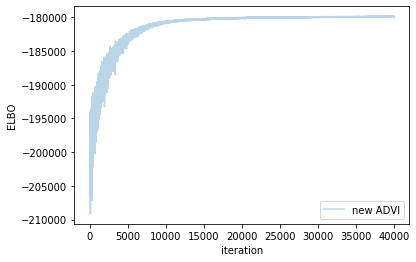

In [232]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
#plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [233]:
print(trace['tau_latent'].shape)

(20000, 120, 3)


In [234]:
# pm.autocorrplot(trace['tau_latent'][:,0,0]);
# pm.autocorrplot(trace['tau_latent'][::20,0,0]);

In [235]:
trace['lambda'].shape

(20000, 4, 4, 27)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

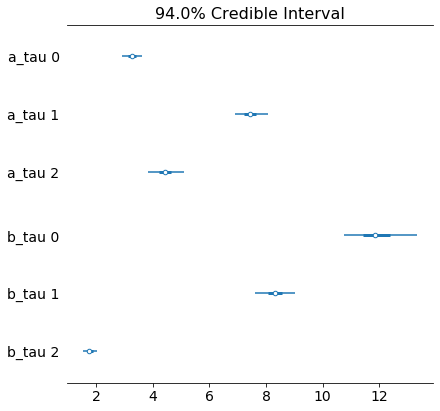

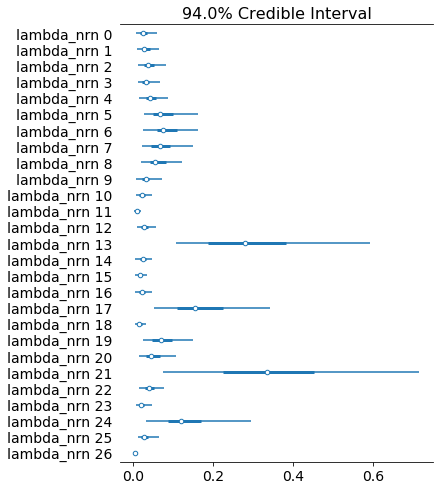

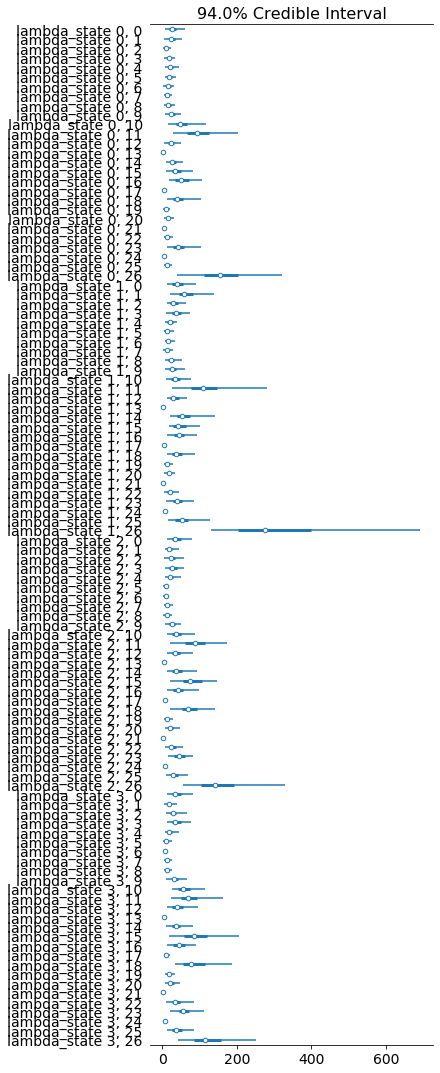

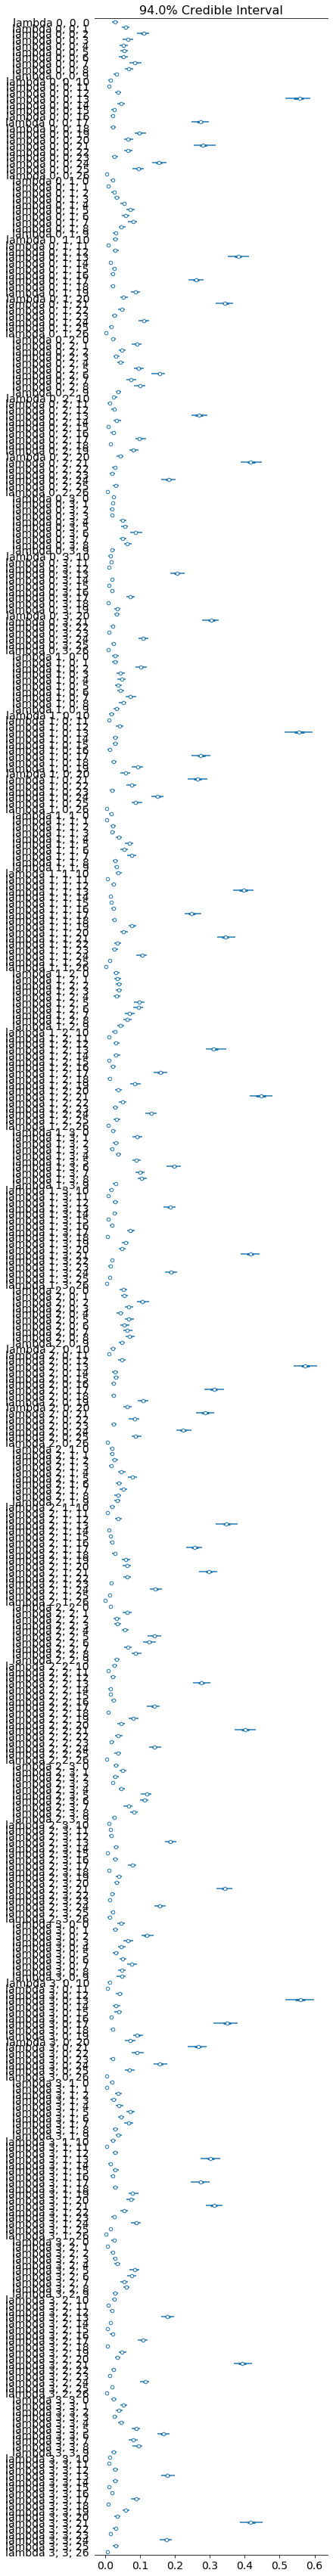

In [236]:
pm.forestplot(trace[::100], var_names = ['a_tau','b_tau']);
pm.forestplot(trace[::100], var_names = ['lambda_nrn']);
# pm.forestplot(trace[::100], var_names = 'tau');
pm.forestplot(trace[::100], var_names = ['lambda_state']);
pm.forestplot(trace[::100], var_names = ['lambda']);

# pm.forestplot(trace, var_names = ['a_tau','b_tau']);
# pm.forestplot(trace, var_names = 'tau');
# pm.forestplot(trace, var_names = ['a_lambda','b_lambda']);
# pm.forestplot(trace, var_names = ['a_lambda_state','b_lambda_state']);
# pm.forestplot(trace, var_names = ['lambda']);

In [237]:
lambda_stack = trace['lambda'].swapaxes(0,1)
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(20000, 120, 3)
(4, 20000, 4, 27)


In [238]:
mean_tau = np.mean(tau_samples, axis=0)
mean_lambda = np.mean(lambda_stack,axis=1).swapaxes(1,2)
print(mean_tau.shape)
print(mean_lambda.shape)

(120, 3)
(4, 27, 4)


(4, 27, 4)
(4, 27, 4)


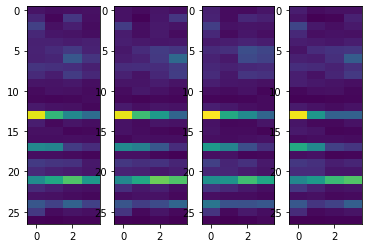

<Figure size 432x288 with 0 Axes>

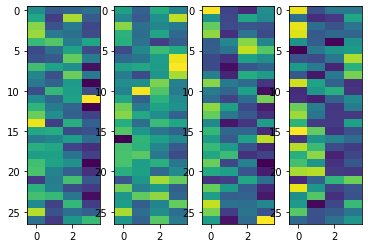

In [239]:
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis',
                                      vmin = 0, vmax = np.max(mean_lambda,axis=None))

plt.figure();
zscore_mean_lambda = np.array([stats.zscore(nrn,axis=None) for nrn in mean_lambda.swapaxes(0,1)]).swapaxes(0,1)
print(mean_lambda.shape)
print(zscore_mean_lambda.shape)
fig,ax = plt.subplots(1,mean_lambda.shape[0]);
for this_ax, this_dat in zip(ax, zscore_mean_lambda):
    this_ax.imshow(this_dat, interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')



In [240]:
# # Chunk subplots by state
# swapped_mean_lambda = mean_lambda.swapaxes(0,-1)
# print(swapped_mean_lambda.shape)
# fig,ax = plt.subplots(1,swapped_mean_lambda.shape[0]);
# for num,(this_ax, this_dat) in enumerate(zip(ax, swapped_mean_lambda)):
#     this_ax.imshow(stats.zscore(this_dat,axis=-1), interpolation = 'nearest', aspect = 'auto', cmap = 'viridis')
#     this_ax.set_title('State {}'.format(num))

In [241]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 2000/2000 [01:46<00:00, 18.80it/s]


(2000, 120, 27, 250)

In [242]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(120, 27, 250)


In [243]:
mean_mean_tau = np.mean(tau_samples,axis=(0,1))
mean_mean_ppc = np.mean(mean_ppc,axis=1)
zscore_mean_mean_ppc = np.array([stats.zscore(nrn,axis=None) for nrn in mean_mean_ppc.swapaxes(0,1)]).swapaxes(0,1)
print(mean_mean_tau.shape)
print(mean_mean_ppc.shape)
print(zscore_mean_mean_ppc.shape)

(3,)
(120, 250)
(120, 250)


(2400000, 3)


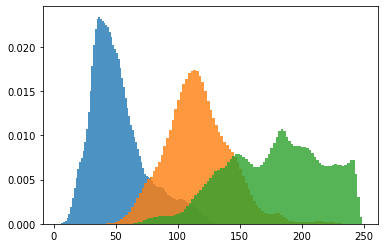

In [244]:
long_tau_samples = tau_samples.reshape((-1, tau_samples.shape[-1]))
print(long_tau_samples.shape)
for switch in range(long_tau_samples.shape[-1]):
     plt.hist(long_tau_samples[...,switch],bins = 100, density = True,alpha = 0.8)
    
# for this_ax in ax[-1,:]:
#     this_ax.set_xticks(np.arange(0,len(binned_t_vec),tick_interval));
#     this_ax.set_xticklabels(binned_t_vec[::tick_interval],rotation='vertical');

In [254]:
zscore_mean_ppc = stats.zscore(mean_ppc, axis=(-1))
print(zscore_mean_ppc.shape)

(120, 27, 250)


In [255]:
plot_spikes = dat_binned_long>0

In [256]:
# channel = 12
# stft_cut = stats.zscore(dat.amplitude_array,axis=-1)
# stft_cut = stft_cut[:,12,...,time_lims[0]:time_lims[1]]
# stft_cut = np.reshape(stft_cut,(-1,*stft_cut.shape[2:]))
# print(stft_cut.shape)
# stft_ticks = dat.time_vec[time_lims[0]:time_lims[1]]*1000
# stft_tick_inds = np.arange(0,len(stft_ticks),250)
# visualize.imshow(np.median(stft_cut,axis=0))

# mean_tau_stft = (mean_tau/np.max(mean_tau,axis=None))*stft_cut.shape[-1]
# print(mean_tau_stft[0])
# print(dat.freq_vec)
# print(mean_tau_stft.shape)
# print(stft_ticks.shape)

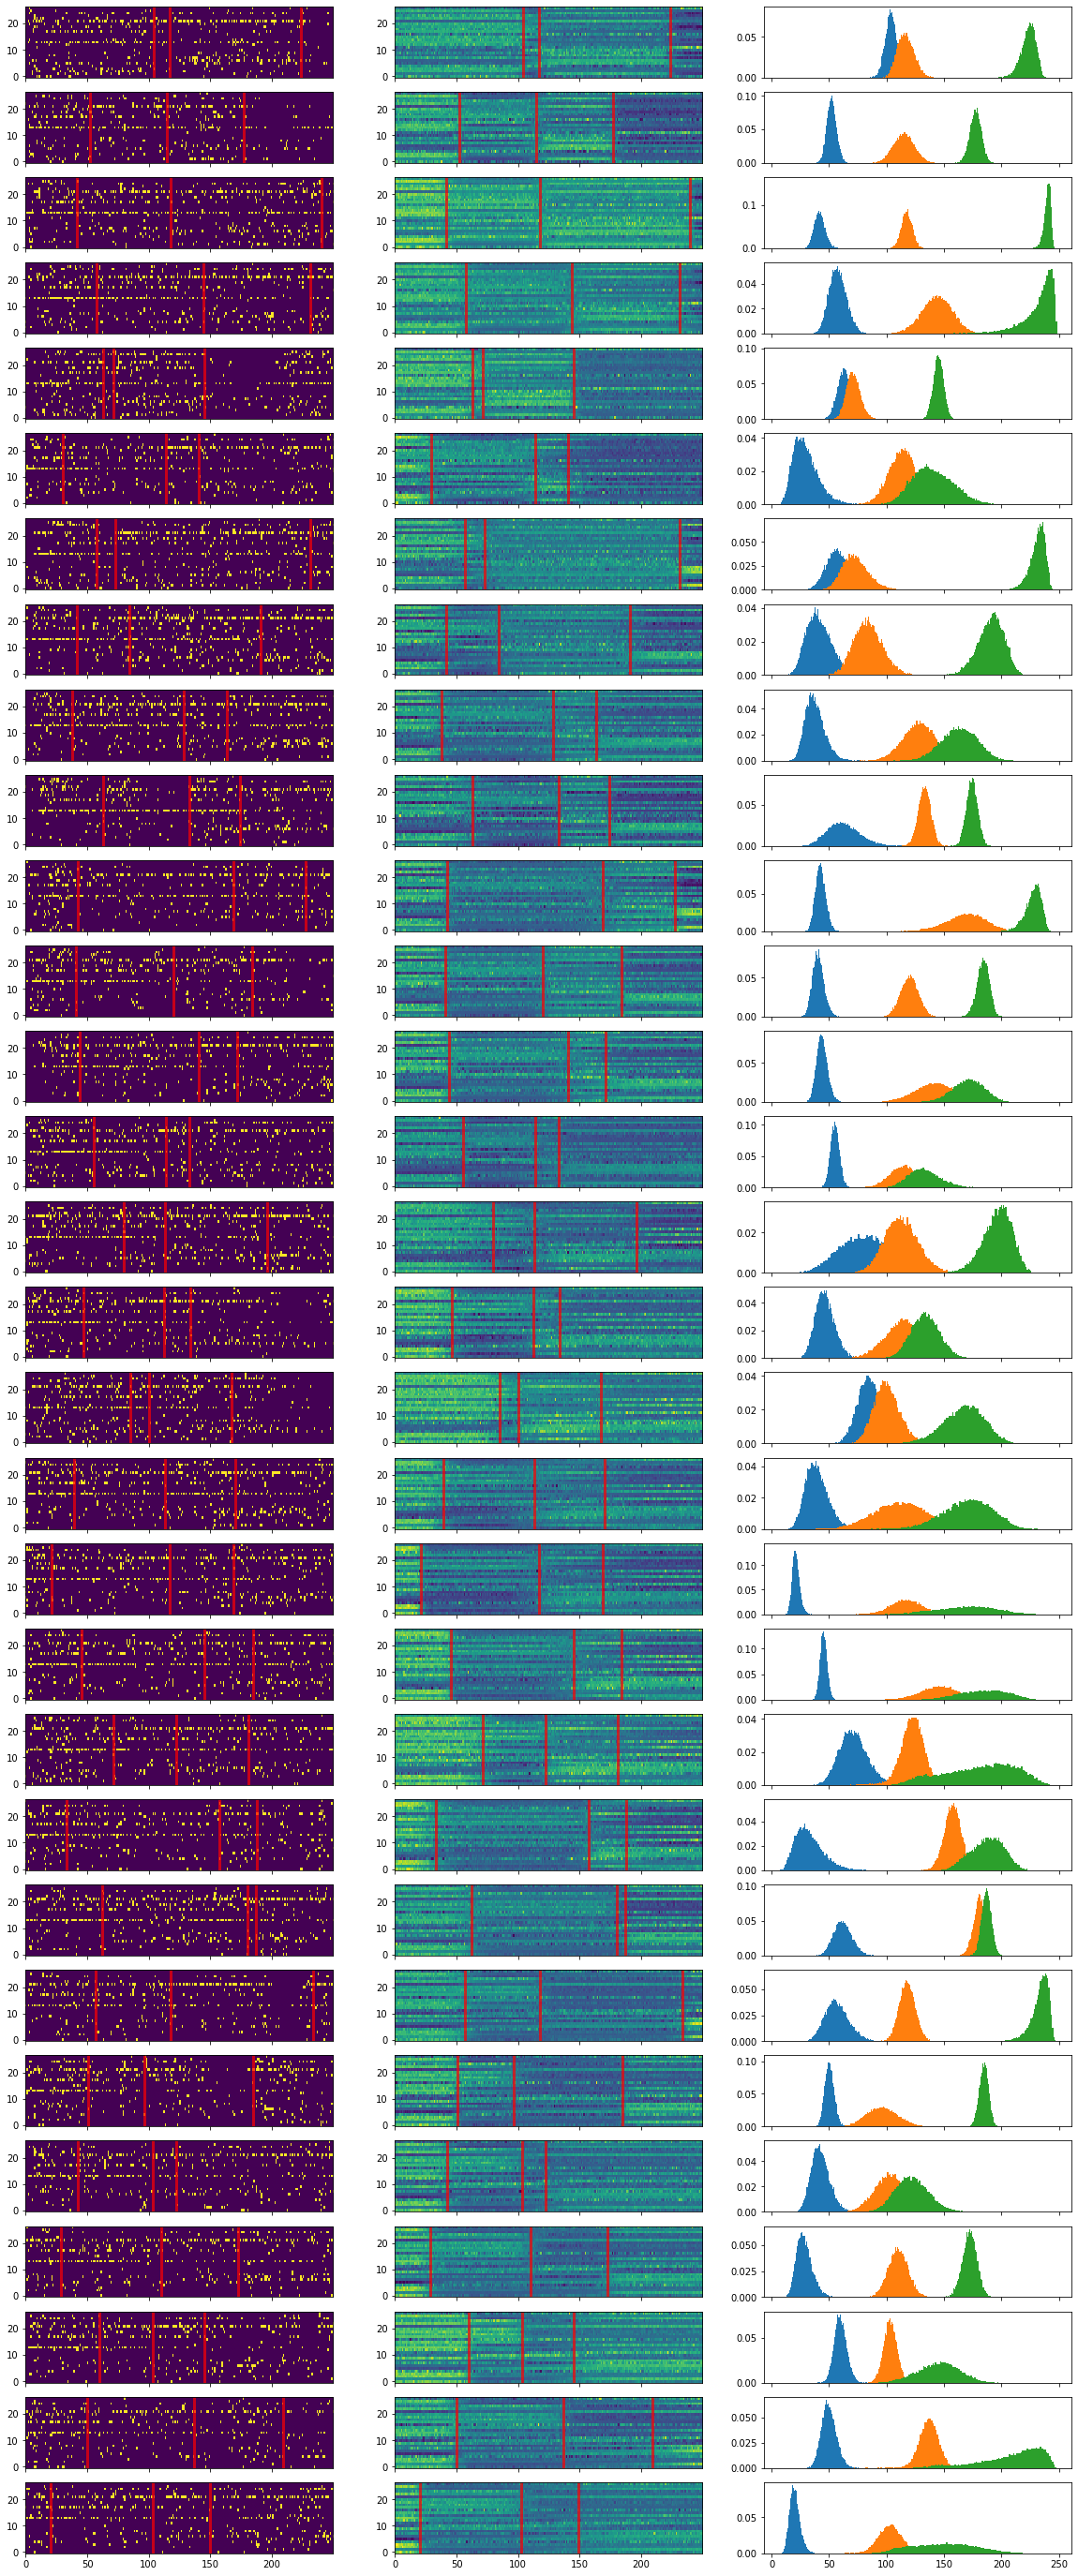

In [257]:
# Overlay raster with CDF of switchpoints
trial_count = 30
tick_interval = 5
trial_inds = np.sort(np.random.choice(np.arange(mean_ppc.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count,3,sharex='col', figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
    #ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    #ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    
    #ax[num,1].set_xticks(stft_tick_inds)
    #ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)

# for col in [0,2,3]:
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [274]:
# Find trials where the mean tau for one changepoint is outside the 95% interval for other taus 
print(mean_tau.shape)
print(tau_samples.shape)
# # pre-compute ecdf for each tau for each trial
# ecdf_list = [[np.histogram(this_tau,200) for this_tau in taus] for taus in tqdm(np.moveaxis(tau_samples,0,-1))]
# print(ecdf_list[0][0])
percentile_array = np.zeros((*mean_tau.shape,mean_tau.shape[-1]))
for trial_num, (this_mean_tau, this_tau_dist) in enumerate(zip(mean_tau, np.moveaxis(tau_samples,0,-1))):
    for tau1_val, this_tau in enumerate(this_mean_tau):
        for tau2_val, this_dist in enumerate(this_tau_dist):
            percentile_array[trial_num, tau1_val, tau2_val] = percentileofscore(this_dist, this_tau)

(120, 3)
(20000, 120, 3)


(120, 3, 3)
[[ 51.91    0.      0.   ]
 [100.     49.405   0.12 ]
 [100.    100.     35.38 ]]


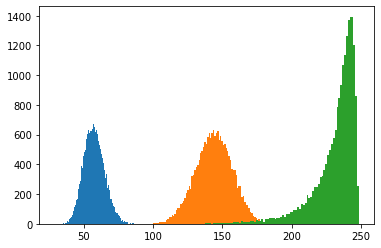

In [305]:
trial = 15
print(percentile_array.shape)
print(percentile_array[trial])
for state in range(tau_samples.shape[-1]):
    plt.hist(tau_samples[:,trial,state],100)

In [318]:
# Visually, threshold of <1 percentile seems compelling
# Find all trials where all the upper triangular elements are <1
# and lower triangular elements are >99
lower_thresh = 1
upper_thresh = 100 - lower_thresh
# print(percentile_array[trial][np.triu_indices(states-1,1)])
# print(sum(percentile_array[trial][np.triu_indices(states-1,1)] < lower_thresh)==(states-1))
# print(percentile_array[trial][np.tril_indices(states-1,-1)])
# print(sum(percentile_array[trial][np.tril_indices(states-1,1)] > upper_thresh)==(states-1))

# x = percentile_array[trial]
# print(sum(x[np.triu_indices(states-1,1)] < lower_thresh)==(states-1))
# print(sum(x[np.triu_indices(states-1,1)] > upper_thresh)==(states-1))
good_trial_list = np.where([sum(x[np.triu_indices(states-1,1)] < lower_thresh)==(states-1) \
                  and sum(x[np.tril_indices(states-1,1)] > upper_thresh)==(states-1) \
                  for x in percentile_array])[0]
print(len(good_trial_list))
print(good_trial_list)

60
[  0   3   4   5   7   9  10  13  15  17  20  26  30  32  33  35  36  37
  38  40  43  44  46  48  50  52  54  55  56  60  61  64  69  71  72  73
  77  78  79  83  91  93  94  95  96  97  98  99 101 102 103 104 108 109
 111 112 114 115 116 117]


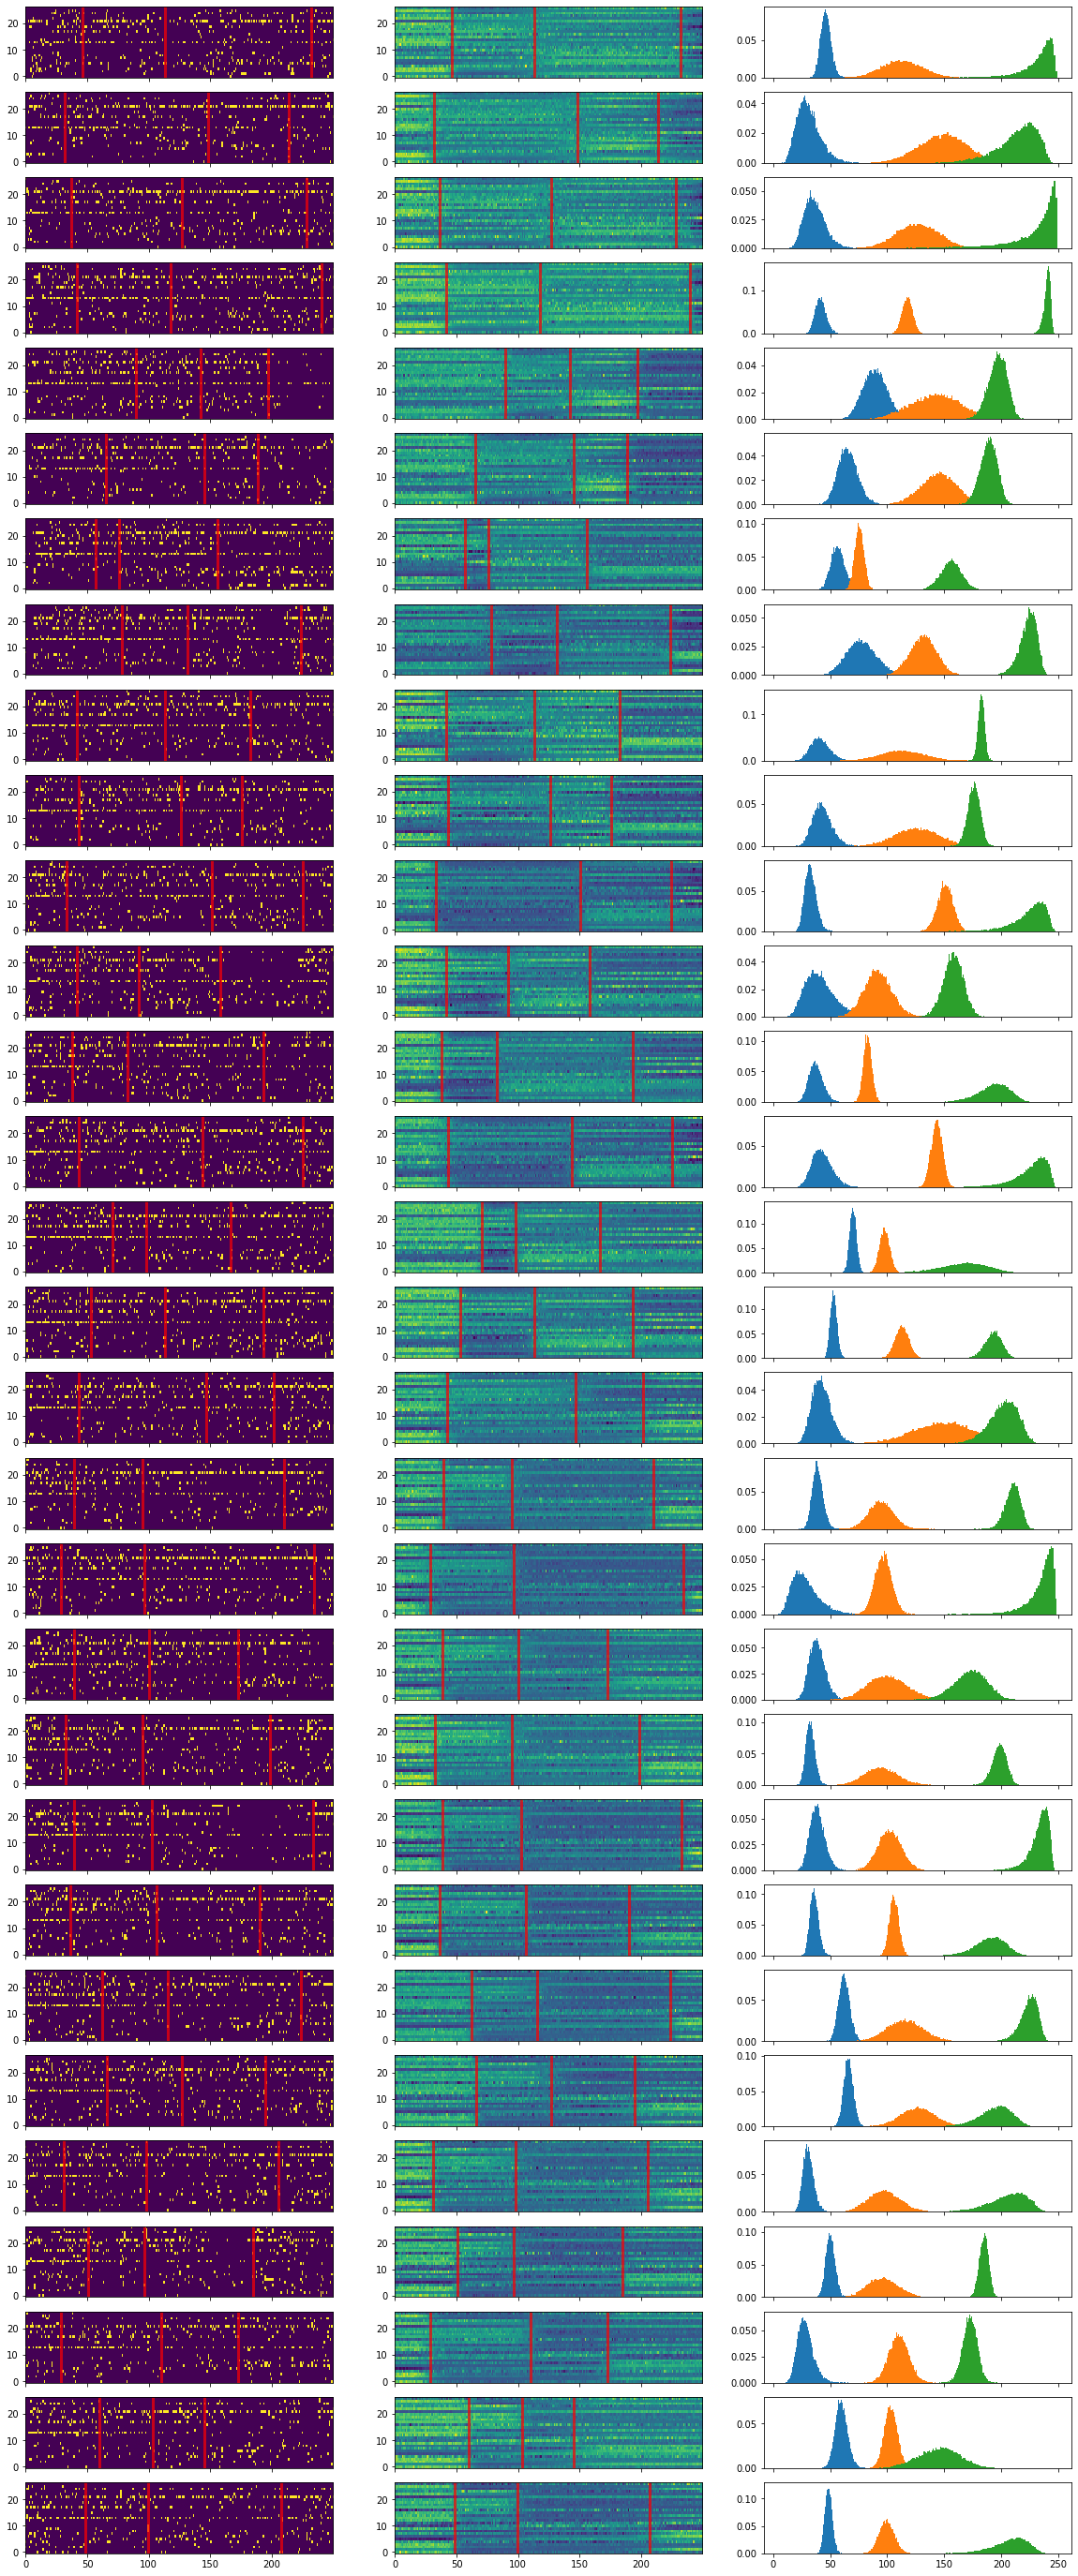

In [321]:
# Plot only good trials
# Overlay raster with CDF of switchpoints
trial_count = 30
tick_interval = 5
trial_inds = np.sort(np.random.choice(good_trial_list,trial_count, replace = False))

fig, ax = plt.subplots(trial_count,3,sharex='col', figsize = (20,50))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(plot_spikes[trial],aspect='auto',origin='lower')
    #ax[num,1].imshow(stft_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(zscore_mean_ppc[trial], aspect='auto',origin='lower')
    ax[num,0].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    #ax[num,1].vlines(mean_tau_stft[trial],-0.5,stft_cut.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    ax[num,1].vlines(mean_tau[trial],-0.5,zscore_mean_ppc.shape[1]-0.5,color = 'red',linewidth = 3, alpha = 0.7)
    
    #ax[num,1].set_xticks(stft_tick_inds)
    #ax[num,1].set_xticklabels(stft_ticks[stft_tick_inds],rotation='vertical')

    for state in range(tau_samples.shape[-1]):
        ax[num,2].hist(tau_samples[:,trial,state], bins = 100, density = True)

# for col in [0,2,3]:
#     plt.sca(ax[-1,col])
#     plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
#     plt.xlim(0,len(binned_t_vec))


In [366]:
# See whether you can extract differences in valve opening times from transition points
taste_tau = []
for taste in sorted(set(taste_label)):
    taste_tau.append(mean_tau[taste_label==taste])
taste_tau = np.array(taste_tau)
print(taste_tau.shape)
taste_mean_tau = np.mean(taste_tau,axis=1)
taste_mean_time = taste_mean_tau[:,0]*bin_width
print(taste_mean_time - np.min(taste_mean_time))

(4, 30, 3)
[19.39527859  0.         62.92193621  1.00473756]


In [367]:
# For visualization
# Take firing around each transition and stack it together to make a PSTH (not mean firing)
# Perform alignemnt on uncut data (0-7000 ms) so there are no missing parts
# (in case a changepoint is too close to the start or the end)
# Before and after alignment
window_radius_time = 300 # ms
window_radius_bins = window_radius_time//bin_width
print(window_radius_bins)

# To translate the changepoints according to the start of the whole trial
mean_tau_adj = mean_tau + (time_lims[0]//bin_width)

# Convert tau to interegers
int_mean_tau = np.vectorize(np.int)(mean_tau_adj)

print(dat_binned_long.shape)
print(int_mean_tau.shape)

30
(120, 27, 250)
(120, 3)


In [368]:
# Take entire radius if available or whatever there is otherwise
# Iterate over changepoints and trials
# trials x neuron x switches x window_diameter
aligned_spikes = np.ones((*whole_dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(aligned_spikes.shape)

(120, 27, 3, 60)


In [369]:
# Spikes aligned to trial-specific transitions
for trial in range(whole_dat_binned_long.shape[0]):
    for switch in range(mean_tau.shape[-1]):
        
        # Check whether we can pick out a window
        lower_bound = (int_mean_tau[trial,switch] - window_radius_bins)
        fin_lower_bound = lower_bound * (lower_bound > 0)
        upper_bound = (int_mean_tau[trial,switch] + window_radius_bins)
        fin_upper_bound = upper_bound * (upper_bound < whole_dat_binned_long.shape[-1]) + \
                                            whole_dat_binned_long.shape[-1] * (upper_bound > whole_dat_binned_long.shape[-1])

        # Done this way so all windows can be accomodated whether they are of the expected size or not
        lower_window = whole_dat_binned_long[trial,:,fin_lower_bound:int_mean_tau[trial,switch]]
        upper_window = whole_dat_binned_long[trial,:,int_mean_tau[trial,switch]:fin_upper_bound]
        #If window is smaller than the expected size, put it in centered on transition
        aligned_spikes[trial,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
        aligned_spikes[trial,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

In [370]:
# Spikes aligned to average transitions
unaligned_spikes = np.ones((*whole_dat_binned_long.shape[:2],mean_tau.shape[-1],window_radius_bins*2))*-1
print(unaligned_spikes.shape)
int_unaligned_tau = np.vectorize(np.int)(np.mean(mean_tau_adj,axis=0))
# Spikes aligned to trial-specific transitions
for switch in range(int_unaligned_tau.shape[-1]):

    # Check whether we can pick out a window
    lower_bound = (int_unaligned_tau[switch] - window_radius_bins)
    fin_lower_bound = lower_bound * (lower_bound > 0)
    upper_bound = (int_unaligned_tau[switch] + window_radius_bins)
    fin_upper_bound = upper_bound * (upper_bound < whole_dat_binned_long.shape[-1]) + \
                                        whole_dat_binned_long.shape[-1] * (upper_bound > whole_dat_binned_long.shape[-1])

    # Done this way so all windows can be accomodated whether they are of the expected size or not
    lower_window = whole_dat_binned_long[:,:,fin_lower_bound:int_unaligned_tau[switch]]
    upper_window = whole_dat_binned_long[:,:,int_unaligned_tau[switch]:fin_upper_bound]
    #If window is smaller than the expected size, put it in centered on transition
    unaligned_spikes[:,:,switch,(window_radius_bins - lower_window.shape[-1]):window_radius_bins] = lower_window
    unaligned_spikes[:,:,switch,window_radius_bins:(window_radius_bins + upper_window.shape[-1])] = upper_window

(120, 27, 3, 60)


In [371]:
# break down aligned_spikes by taste
aligned_list = []
for taste in sorted(set(taste_label)):
    aligned_list.append(aligned_spikes[taste_label==taste])
taste_aligned_spikes = np.array(aligned_list)
print(taste_aligned_spikes.shape)

(4, 30, 27, 3, 60)


(27, 3, 120, 60)


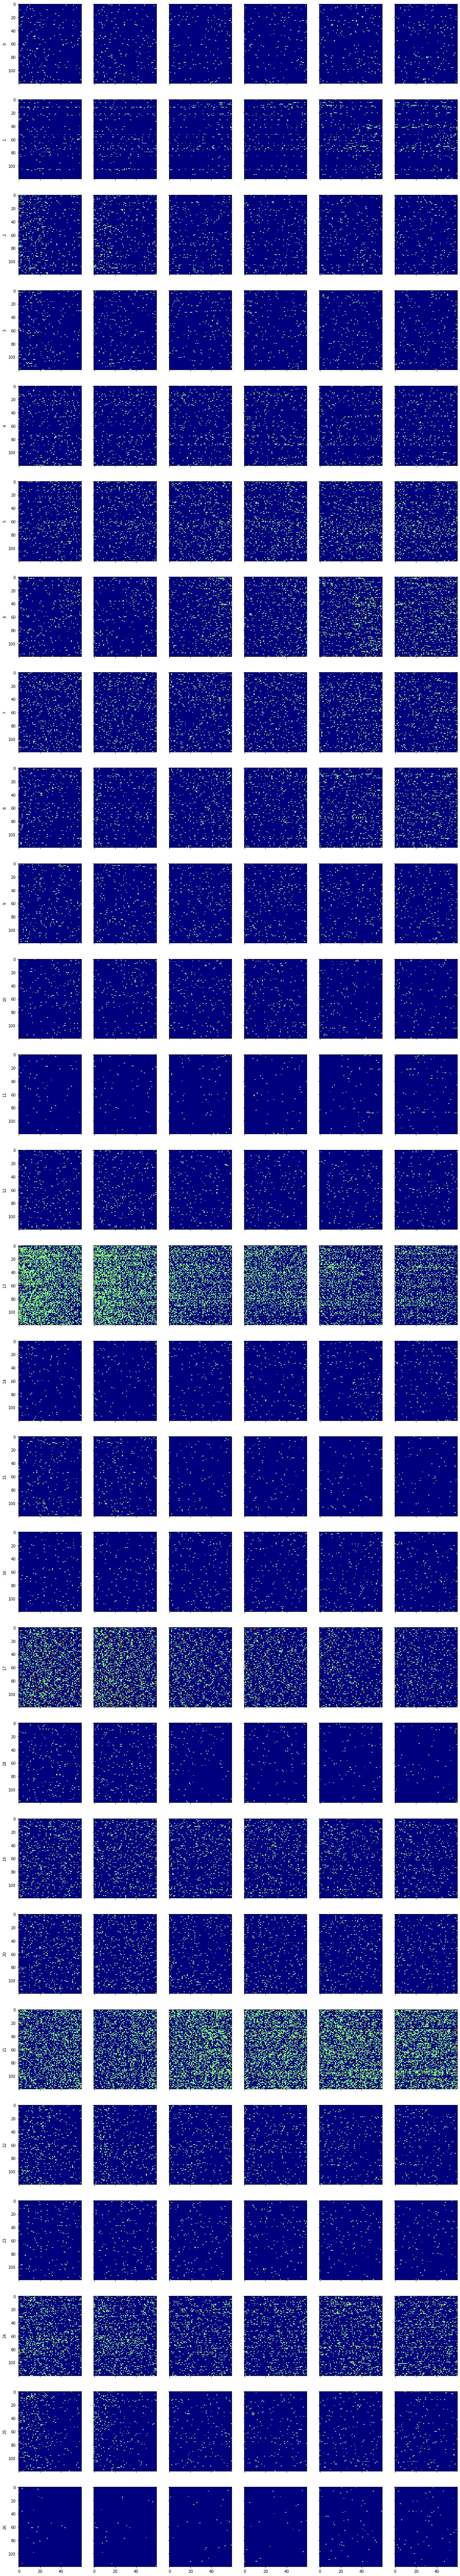

In [372]:
plot_dat_aligned = np.moveaxis(aligned_spikes,0,2)
plot_dat_unaligned = np.moveaxis(unaligned_spikes,0,2)
print(plot_dat_aligned.shape)

fig, ax = plt.subplots(plot_dat_aligned.shape[0],plot_dat_aligned.shape[1]*2,
                      sharex=True, sharey=True, figsize=(20,120))
iters = np.ndindex(plot_dat_aligned.shape[:2])
for this_iter in iters:
    #spikes = np.where(plot_dat[this_iter])
    #this_ax.scatter(spikes[1],spikes[0],s=2,alpha=0.7,marker = "|")
    ax[this_iter[0],2*this_iter[1]].imshow(plot_dat_aligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=0,vmax=2)
    ax[this_iter[0],(2*this_iter[1])+1].imshow(plot_dat_unaligned[this_iter[0],this_iter[1]],aspect='auto',cmap='jet',vmin=0,vmax=2)
    
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
    

(27, 3, 4, 60)


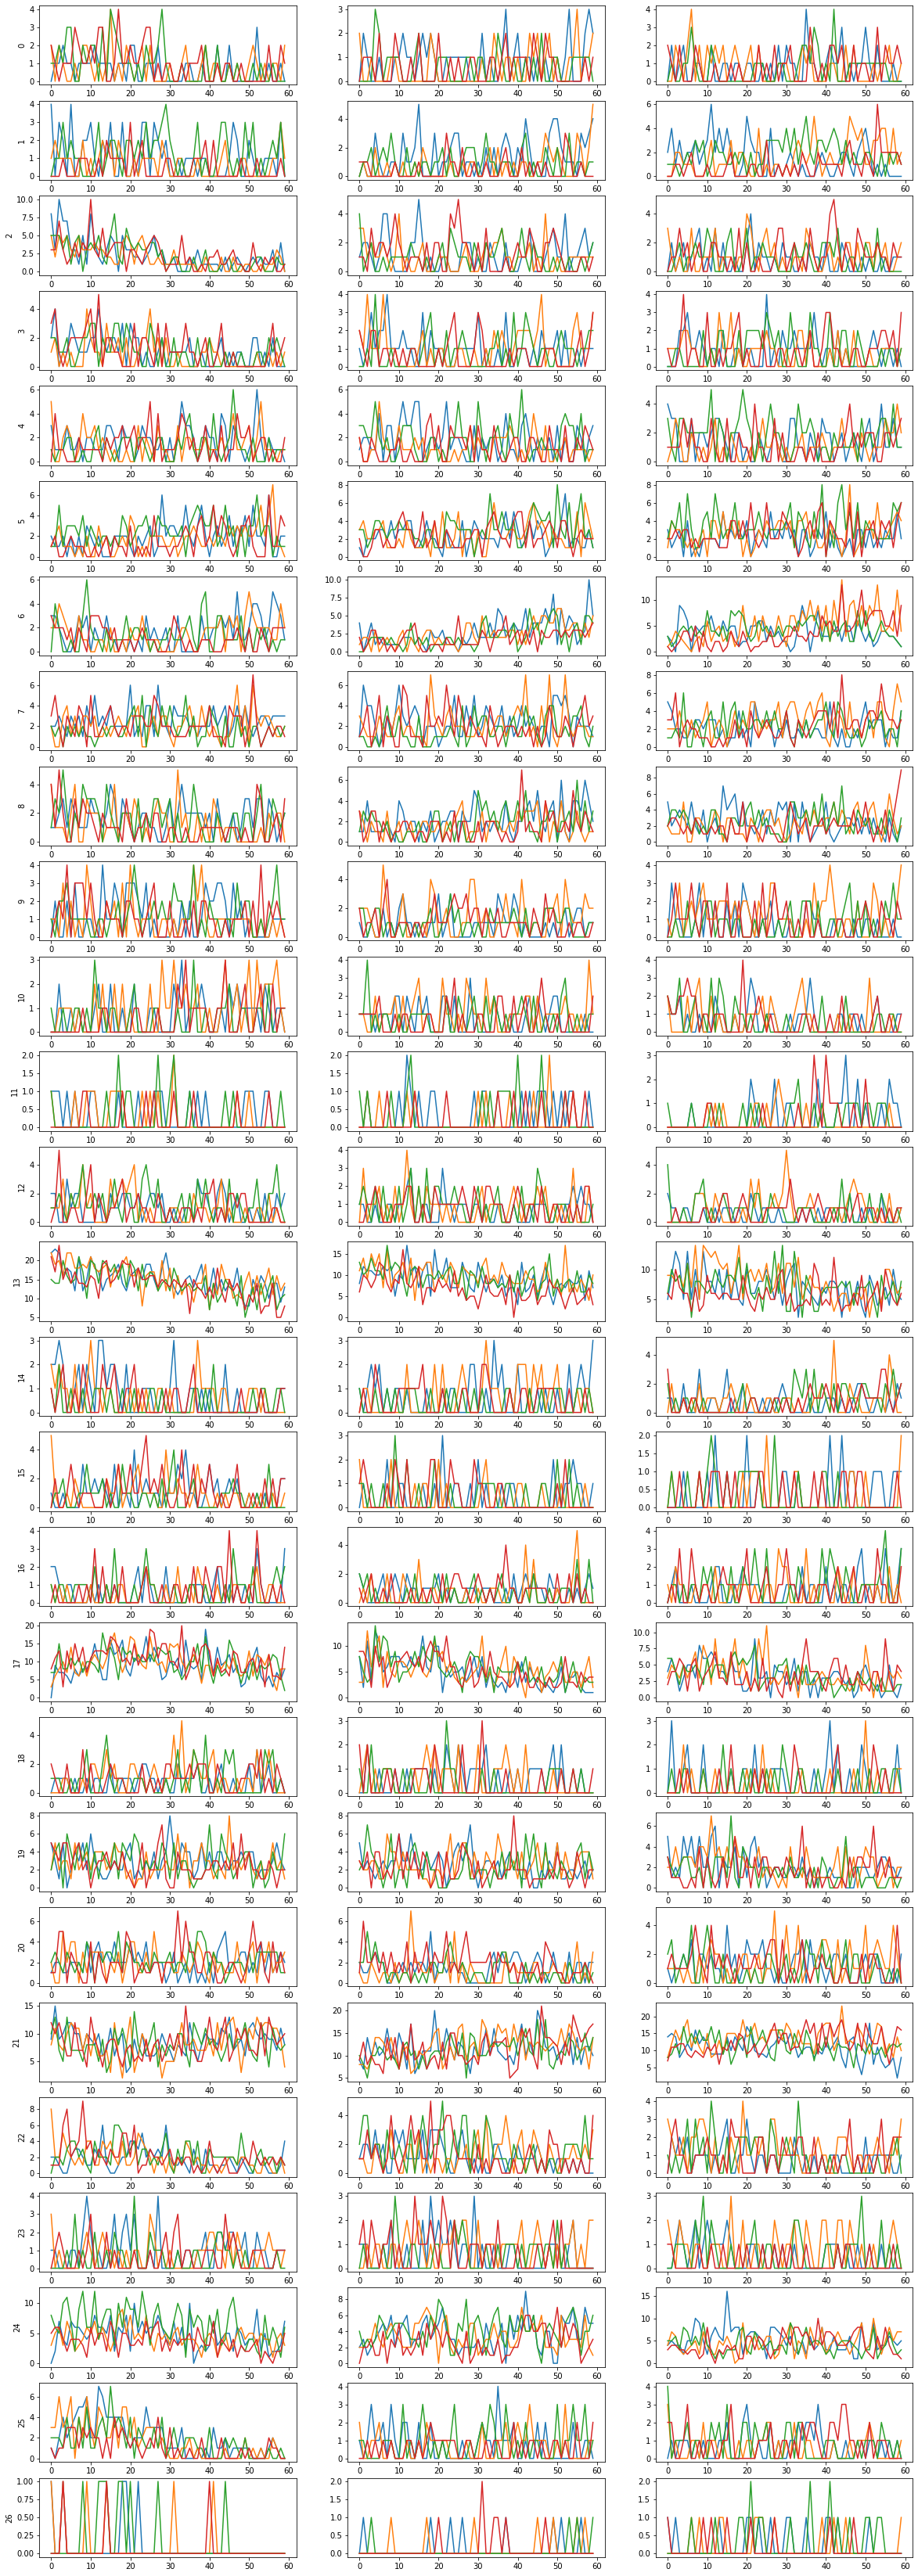

In [373]:
sum_aligned_taste_spikes = np.moveaxis(np.sum(taste_aligned_spikes,axis=1),0,2)
print(sum_aligned_taste_spikes.shape)
fig, ax = plt.subplots(sum_aligned_taste_spikes.shape[0],sum_aligned_taste_spikes.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_taste_spikes[this_iter].T)
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)

(27, 3, 60)
(27, 3, 60)


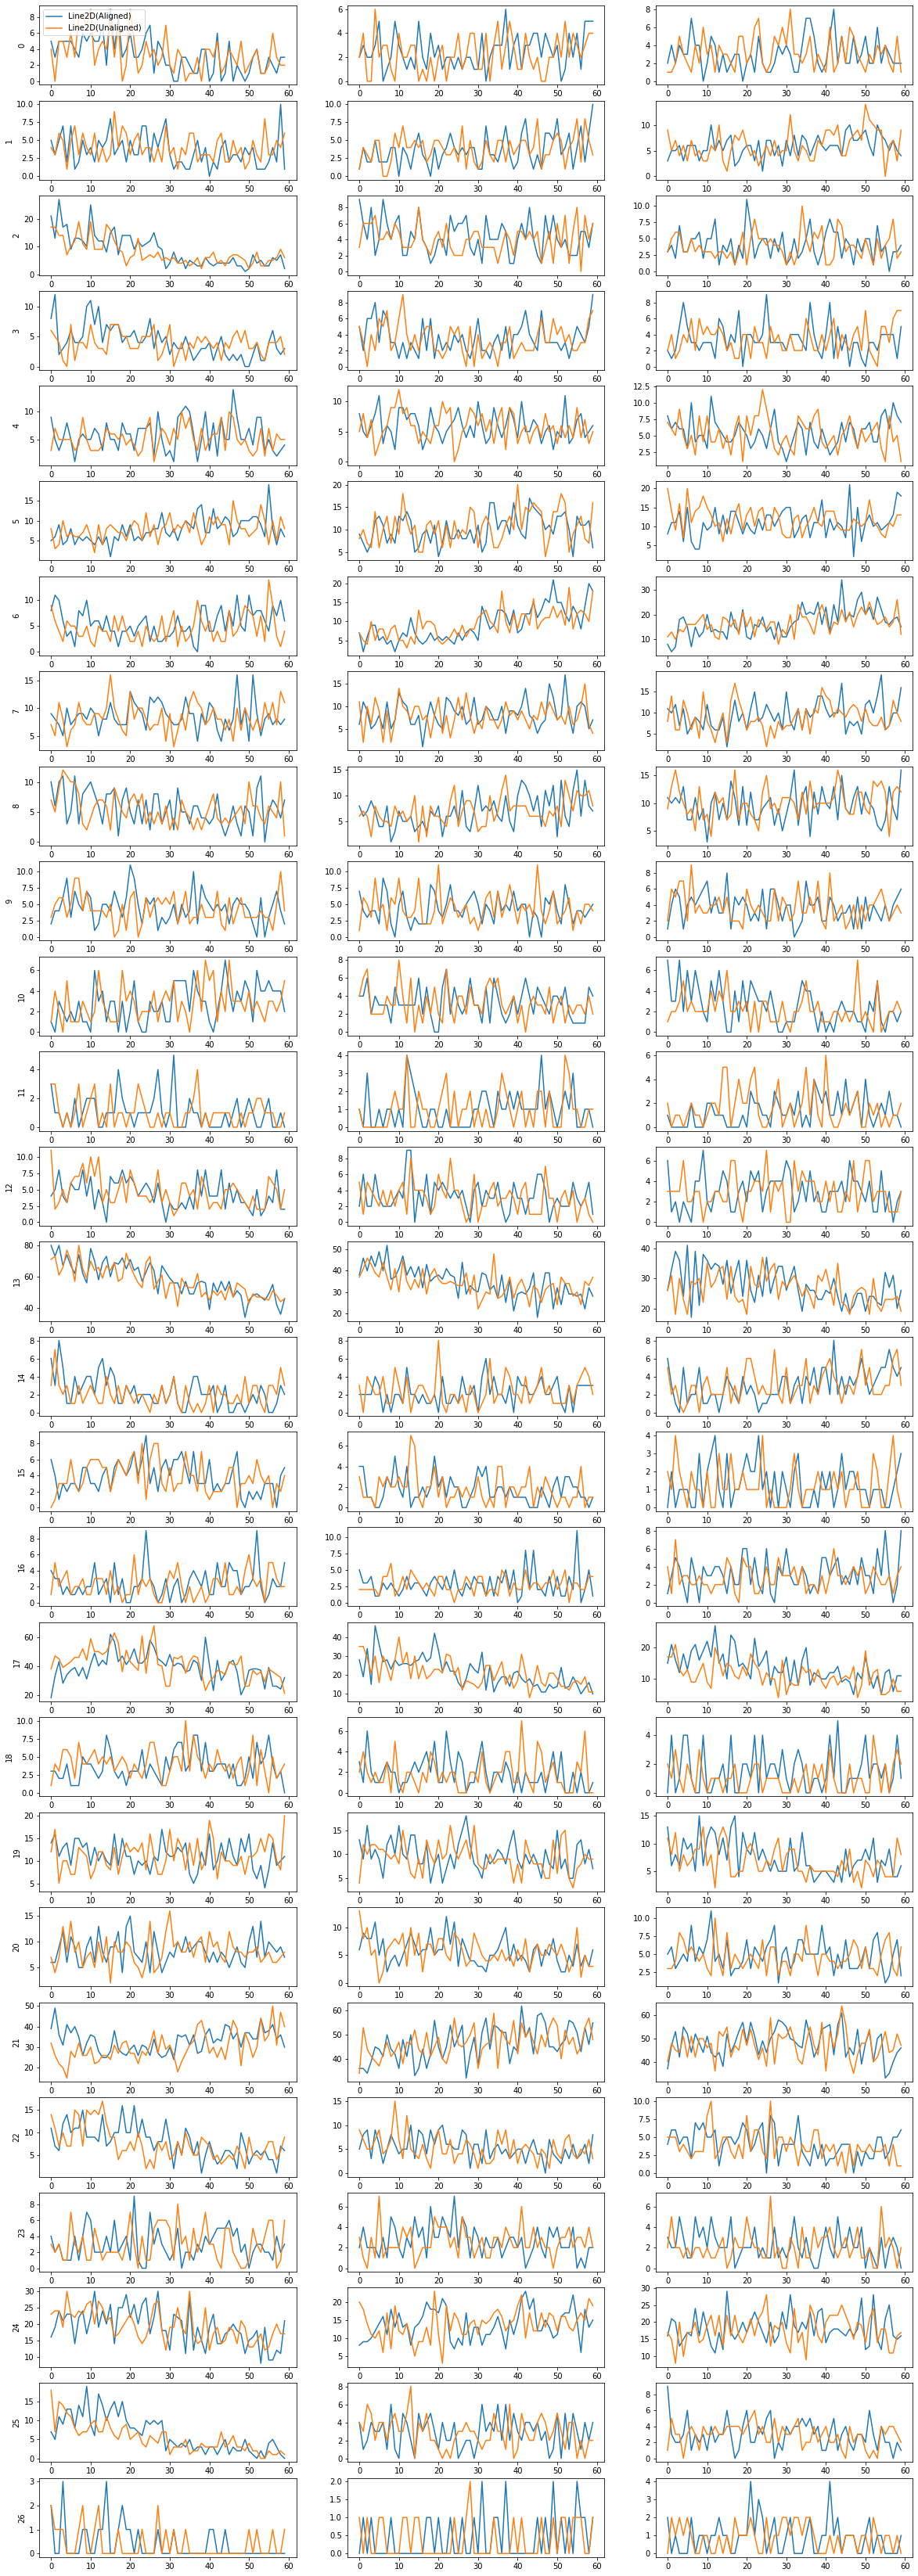

In [374]:
## Compare mean aligned psth (across all tastes) to mean psth at mean changepoint time
sum_aligned_spikes = np.sum(plot_dat_aligned,axis=2)
sum_unaligned_spikes = np.sum(plot_dat_unaligned,axis=2)
print(sum_aligned_spikes.shape)
print(sum_unaligned_spikes.shape)
fig, ax = plt.subplots(sum_aligned_spikes.shape[0],sum_aligned_spikes.shape[1],
                      figsize = (20,60))
iters = np.ndindex(ax.shape)
for this_iter,this_ax in zip(iters,ax.flatten()):
    this_ax.plot(sum_aligned_spikes[this_iter])
    this_ax.plot(sum_unaligned_spikes[this_iter])
for num,this_ax in enumerate(ax[:,0].flatten()):
    this_ax.set_ylabel(num)
plt.sca(ax[0,0])
plt.legend([Line2D([0],[0],label = 'Aligned',color='blue'), 
            Line2D([0],[0],label = 'Unaligned', color = 'orange')],
          loc = 'upper left');

In [375]:
# Calculate palatability correlations from the aligned spikes
# Can do aligned firing rate next
info_file_path = glob.glob(os.path.join(data_dir,'**.info'))[0]
print(info_file_path)
with open(info_file_path,'r') as file_connect:
    info_dict = json.load(file_connect)
pal_rankings = np.squeeze(info_dict['taste_params']['pal_rankings'])
print(pal_rankings)
print(plot_dat_aligned.shape)

/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200228_151511/AS18_4Tastes_200228_151511.info
[3 4 2 1]
(27, 3, 120, 60)


In [385]:
pal_vec = np.repeat(pal_rankings,plot_dat_aligned.shape[2]//len(pal_rankings))
aligned_dat_for_corr = np.moveaxis(plot_dat_aligned,-2,-1)
print(aligned_dat_for_corr.shape)
aligned_inds = list(np.ndindex(aligned_dat_for_corr.shape[:-1]))
aligned_spearman = np.zeros(aligned_dat_for_corr.shape[:-1])
for this_ind in aligned_inds:
    aligned_spearman[this_ind] = spearmanr(aligned_dat_for_corr[this_ind], pal_vec)[0]

print(aligned_spearman.shape)
mean_aligned_spearman_r = np.nanmean(aligned_spearman,axis=0)

# Perform Fisher's Z transform for averaging and then revert
# z_aligned_spearman_r = np.arctanh(aligned_spearman)
# mean_z_aligned_spearman_r = np.mean(z_aligned_spearman_r,axis=0)
# mean_aligned_spearman_r = np.tanh(mean_z_aligned_spearman_r)
# print(mean_aligned_spearman_r.shape)

(27, 3, 60, 120)
(27, 3, 60)


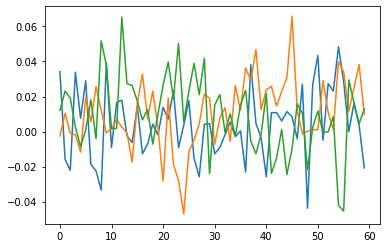

In [386]:
plt.plot(mean_aligned_spearman_r.T)

(27, 120, 700)


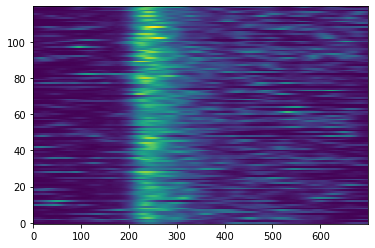

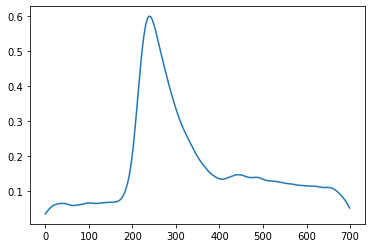

In [403]:
# Well...that was garbage
# Align BAKS firing rates and use them for correlation
visualize.imshow(dat.all_normalized_firing[17])
plt.figure();
plt.plot(np.mean(dat.all_normalized_firing[17],axis=0))
print(dat.all_normalized_firing.shape)